# 1.SETUP

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [12]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


'''
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
'''

# 2.MANUAL ML APPROACH

## 2.1.EXPLORATORY DATA ANALYSIS

In [4]:
###Check for missing values###
#Get names of columns with missing values
cols_with_missing = [col for col in train_data.columns
                     if train_data[col].isnull().any()]
cols_with_missing

['Age', 'Cabin', 'Embarked']

In [6]:
#Count missing values in each column
missing_value_count_by_column = (train_data.isnull().sum())
missing_percentage_by_column = (train_data.isnull().sum()/len(train_data))*100

#The cabin column has 77% missing values, so we will drop it


In [14]:
#Handle Missing Values
#Coumne Sex and Cabin seems importans so we will fill missing values and 
# turn them into numerical values

train_data['Age'].fillna(int(train_data['Age'].mean()), inplace=True) #fill missing values with mean
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True) #fill missing values with mode  (most frequent value)

#Encode Categorical Variables
train_data['Sex']=train_data['Sex'].map({'male':0,'female':1})
train_data['Embarked']=train_data['Embarked'].map({'S':0,'C':1,'Q':2})

In [7]:
#count distinct values in each column
distinct_values = train_data.nunique()
distinct_percentage = (train_data.nunique()/len(train_data))*100

#For some columns, More distinct values the better for modelled data, hence the data is no unary 

Text(0.5, 1.0, 'Correlation matrix Numeric data')

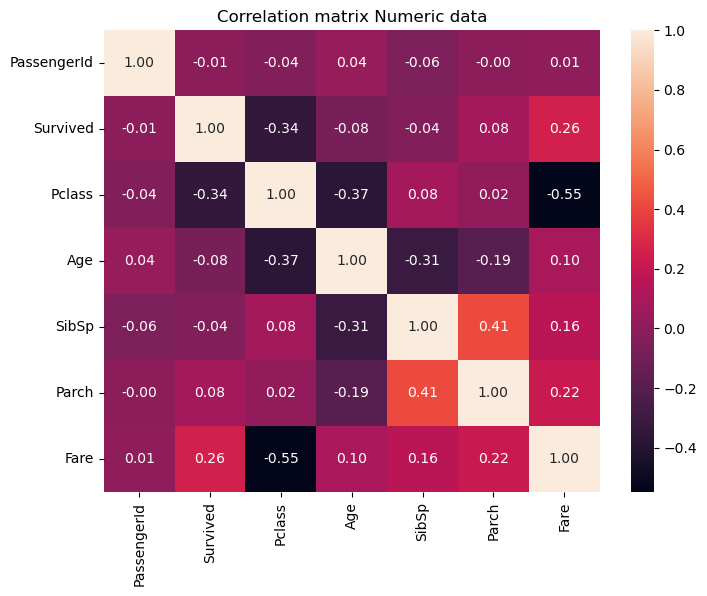

In [3]:
#See corelation between columns
import seaborn as sns
import matplotlib.pyplot as plt



numeric_data = train_data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation matrix Numeric data")

<Axes: xlabel='Age', ylabel='Count'>

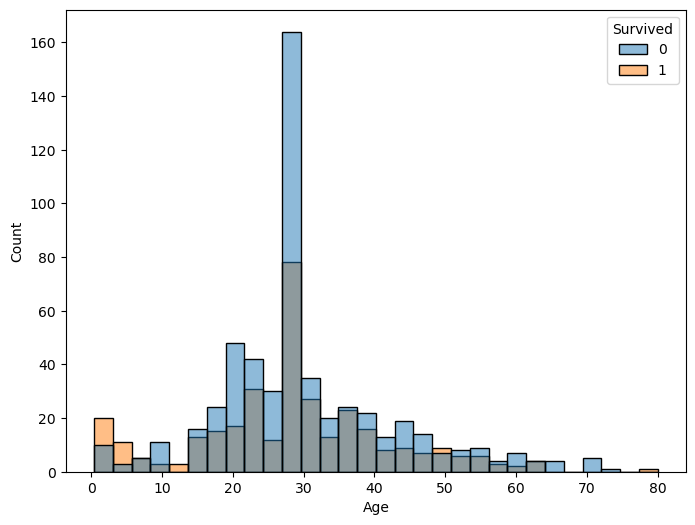

In [22]:
#Survival by Sex histogram
plt.figure(figsize=(8, 6))
sns.histplot(data = train_data, x = 'Age', hue = 'Survived')


## 2.2.FEATURES SELECTION

In [61]:
#Select Features
features = ['Sex','Pclass','Embarked']#'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'
#Select Target
target = ['Survived']
X = train_data[features]
y = train_data[target]

## 2.3.DATA PREPROCESSING & MODELLING

In [62]:
#Create Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

# Custom transformer to convert float to int
def convert_to_int(X):
    return pd.DataFrame(X).astype(int).values

# Custom transformer to map categorical values
def map_sex(X):
    return pd.DataFrame(X).replace({'male': 0, 'female': 1}).values

def map_embarked(X):
    return pd.DataFrame(X).replace({'S': 0, 'C': 1, 'Q': 2}).values

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('convert_to_int', FunctionTransformer(convert_to_int))
])

# Preprocessing for categorical data using map
sex_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('map_sex', FunctionTransformer(map_sex))
])

embarked_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('map_embarked', FunctionTransformer(map_embarked))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        #('num', numerical_transformer, ['Age']),
        ('sex', sex_transformer, ['Sex']),
        ('embarked', embarked_transformer, ['Embarked'])
    ])

In [63]:
#Create model with AutoML Pycaret
from pycaret.classification import *

merged_df = pd.concat([X, y], axis=1)
clf=setup(data = merged_df, target = 'Survived')
best_model = compare_models()
model=create_model(best_model)
tuned_model= tune_model(model)
#evaluate_model(tuned_model)
final_model=finalize_model(tuned_model)

,Description,Value
0,Session id,8464
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 4)"
4,Transformed data shape,"(891, 4)"
5,Transformed train set shape,"(623, 4)"
6,Transformed test set shape,"(268, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8153,0.8222,0.6034,0.8773,0.7093,0.5832,0.6082,0.0100
dt,Decision Tree Classifier,0.8136,0.8573,0.6034,0.8742,0.7083,0.5803,0.6049,0.0050
et,Extra Trees Classifier,0.8136,0.8569,0.6034,0.8742,0.7083,0.5803,0.6049,0.0220
catboost,CatBoost Classifier,0.8136,0.8591,0.6034,0.8742,0.7083,0.5803,0.6049,0.2690
rf,Random Forest Classifier,0.8104,0.8574,0.6034,0.8663,0.7045,0.5738,0.5982,0.0270
gbc,Gradient Boosting Classifier,0.8104,0.8590,0.6034,0.8663,0.7045,0.5738,0.5982,0.0160
xgboost,Extreme Gradient Boosting,0.8104,0.8577,0.6034,0.8663,0.7045,0.5738,0.5982,0.0090
lightgbm,Light Gradient Boosting Machine,0.8104,0.8578,0.6034,0.8663,0.7045,0.5738,0.5982,0.0280
ridge,Ridge Classifier,0.7912,0.8564,0.6911,0.7514,0.7171,0.5525,0.5566,0.0070
qda,Quadratic Discriminant Analysis,0.7912,0.8522,0.6911,0.7514,0.7171,0.5525,0.5566,0.0050


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8730,0.8584,0.7083,0.9444,0.8095,0.7172,0.7339
1,0.8254,0.8056,0.6667,0.8421,0.7442,0.6144,0.6240
2,0.8413,0.8397,0.5833,1.0000,0.7368,0.6341,0.6814
3,0.8871,0.9409,0.8261,0.8636,0.8444,0.7559,0.7564
4,0.6935,0.7111,0.3333,0.7273,0.4571,0.2826,0.3243
5,0.7419,0.7928,0.5000,0.7500,0.6000,0.4206,0.4394
6,0.8387,0.8289,0.5833,1.0000,0.7368,0.6318,0.6796
7,0.8387,0.8109,0.6250,0.9375,0.7500,0.6379,0.6664
8,0.8065,0.8520,0.6250,0.8333,0.7143,0.5724,0.5860


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8730,0.8579,0.7083,0.9444,0.8095,0.7172,0.7339
1,0.8413,0.8536,0.6667,0.8889,0.7619,0.6465,0.6615
2,0.8095,0.9231,0.5000,1.0000,0.6667,0.5532,0.6183
3,0.8871,0.9487,0.8261,0.8636,0.8444,0.7559,0.7564
4,0.6935,0.7029,0.3333,0.7273,0.4571,0.2826,0.3243
5,0.7419,0.8279,0.5000,0.7500,0.6000,0.4206,0.4394
6,0.8387,0.8969,0.5833,1.0000,0.7368,0.6318,0.6796
7,0.8387,0.8240,0.6250,0.9375,0.7500,0.6379,0.6664
8,0.8065,0.8383,0.5833,0.8750,0.7000,0.5654,0.5908


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [56]:
#check Cros Validation Score for the tuned model
cv_score = pull()
cv_score

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6190,0.7420,0.7083,0.5000,0.5862,0.2522,0.2654
1,0.6190,0.6822,0.7500,0.5000,0.6000,0.2632,0.2831
2,0.6825,0.8638,0.9167,0.5500,0.6875,0.4034,0.4591
3,0.7419,0.8388,0.8750,0.6176,0.7241,0.4949,0.5216
4,0.5161,0.7045,0.6667,0.4211,0.5161,0.0792,0.0877
5,0.6613,0.8745,0.8750,0.5385,0.6667,0.3599,0.4047
6,0.6290,0.7774,0.8333,0.5128,0.6349,0.2989,0.3361
7,0.5968,0.8109,0.7917,0.4872,0.6032,0.2380,0.2676
8,0.6290,0.8070,0.9583,0.5111,0.6667,0.3267,0.4142


In [ ]:
#Create Model Using AutoML KERAS

## 2.4.TRAINING & PREDICTION DATA

In [57]:
#Create Bundle Preprocessing Pipeline and Model
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier_model', tuned_model)
                     ])

#Fit the model
#model.fit(X, y)


In [58]:
#Fit the model
model.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='mean')),
                                                                  ('convert_to_int',
                                                                   FunctionTran...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

In [59]:
#Predict on test data
test_data = pd.read_csv('test.csv')
X_test = test_data[features]
y_predict=model.predict(X_test)

In [60]:
#Output to .csv
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_predict})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!


# AUTO ML APPROACH

In [3]:
#Create model with AutoML Pycaret
from pycaret.classification import *
s=setup(data = train_data, target = 'Survived')

,Description,Value
0,Session id,1136
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 12)"
4,Transformed data shape,"(891, 14)"
5,Transformed train set shape,"(623, 14)"
6,Transformed test set shape,"(268, 14)"
7,Numeric features,6
8,Categorical features,5
9,Rows with missing values,79.5%


In [4]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8267,0.8837,0.7076,0.8177,0.7560,0.6233,0.6293,0.3620
ridge,Ridge Classifier,0.7609,0.8798,0.4647,0.8438,0.5964,0.4472,0.4886,0.0230
et,Extra Trees Classifier,0.7400,0.0000,0.4236,0.8217,0.5492,0.3951,0.4421,0.0340
nb,Naive Bayes,0.6661,0.0000,0.1799,0.8078,0.2854,0.1729,0.2567,0.0190
knn,K Neighbors Classifier,0.6310,0.0000,0.4069,0.5169,0.4509,0.1830,0.1863,0.1860
lda,Linear Discriminant Analysis,0.6309,0.5317,0.0522,0.0800,0.0632,0.0479,0.0502,0.0180
rf,Random Forest Classifier,0.6276,0.0000,0.0418,0.5833,0.0776,0.0413,0.1038,0.0420
svm,SVM - Linear Kernel,0.6230,0.6566,0.4100,0.5699,0.4225,0.1761,0.2038,0.0190
dt,Decision Tree Classifier,0.6164,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0180
ada,Ada Boost Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190


In [5]:
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1136, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
tuned_model= tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.7714,0.5417,0.8125,0.6500,0.4966,0.5185
1,0.8095,0.8910,0.7083,0.7727,0.7391,0.5896,0.5910
2,0.8413,0.9049,0.7083,0.8500,0.7727,0.6523,0.6587
3,0.8871,0.9498,0.8261,0.8636,0.8444,0.7559,0.7564
4,0.8871,0.9243,0.8333,0.8696,0.8511,0.7602,0.7607
5,0.8548,0.8783,0.7500,0.8571,0.8000,0.6869,0.6906
6,0.7742,0.8805,0.5417,0.8125,0.6500,0.4930,0.5151
7,0.7903,0.8750,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.8065,0.8969,0.6250,0.8333,0.7143,0.5724,0.5860


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [26]:
#tuned_model
final_model = finalize_model(tuned_model) # Train with all data in data training

In [27]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [28]:
#Get the list of selected features
selected_features = get_config('X').columns.tolist()
print(f"Selected Features: {selected_features}")

Selected Features: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [29]:
y_predict = predict_model(final_model, data = test_data)


In [30]:
#Output to .csv
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_predict.prediction_label})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
